<a href="https://colab.research.google.com/github/astrfo/RS_init/blob/main/RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RS 実装

[満足化を通じた最適な自律的探索] https://www.jstage.jst.go.jp/article/pjsai/JSAI2018/0/JSAI2018_1Z304/_article/-char/ja/

[論文要約] https://colab.research.google.com/drive/199SxVBGDdkuzSzU9pjVP9BfMPzaypLfj#scrollTo=UUSaBpguVsBB




In [117]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
class Environment(object):

    def __init__(self, K):
        self._K = K
        self.prob = [np.random.rand() for _ in range(K)]   #一様分布からサンプリング
        print(f'{self.prob}')

    def play(self, arm):
        if self.prob[arm] > random.random():
            return 1
        else:
            return 0

In [119]:
class Agent(object):

    def __init__(self, K):
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.RS = None
        self.aleph = 1.0        #必ず非満足状態になるように

    def initialize(self):
        self._V = np.array([0.5] * self._K)
        self._n = np.array([sys.float_info.min] * self._K)      #RS式でゼロ除算を防ぐため
        self._N = 0
        self.RS = np.zeros(self._K)     #RSの初期値はゼロ？？

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + self._alpha * reward
        self._n[arm] += 1
        self._N += 1
        self.RS[arm] = self._n[arm] / self._N * (self._V[arm] - self.aleph)     #RS評価値の更新(これは後で分ける？)

    def select_arm(self):
        maxRS = np.amax(self.RS)
        maxIndex = np.where(self.RS == maxRS)[0]
        return random.choice(maxIndex)

In [140]:
class Simulator(object):
    
    def __init__(self, trial, step, K):
        self._agent = Agent(K)
        self._env = Environment(K)
        self._prob = self._env.prob
        self._trial = trial
        self._step = step
        self._regret = np.zeros((trial, step))

    def run(self):
        for t in range(self._trial):
            self._agent.initialize()
            for s in range(self._step):
                arm = self._agent.select_arm()
                reward = self._env.play(arm)
                self._agent.update(arm, reward)
                print(f'arm: {arm}, reward: {reward}')
                self.calc_regret(t, s, arm)
            print(f'{self._agent.RS}')
        self.print_regret()

    def calc_regret(self, t, s, arm):
        self._regret[t][s] += max(self._prob) - self._prob[arm]
        if s != 0: self._regret[t][s] += self._regret[t][s-1]

    def print_regret(self):
        plt.plot(np.arange(self._step), np.mean(self._regret, axis=0), label='RS')
        plt.xlabel('steps')
        plt.ylabel('regret')
        plt.legend()
        plt.show()

[0.31818898999032175, 0.9533777464302882]
arm: 0, reward: 1
arm: 1, reward: 1
arm: 1, reward: 1
arm: 0, reward: 0
arm: 1, reward: 1
arm: 1, reward: 1
arm: 1, reward: 1
arm: 1, reward: 1
arm: 1, reward: 1
arm: 1, reward: 1
[-0.25  0.  ]


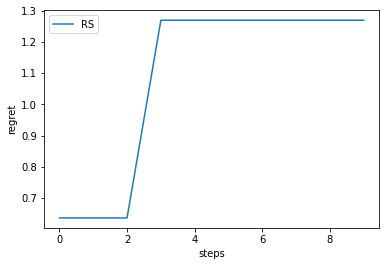

In [144]:
trial = 1
step = 10
K = 2
sim = Simulator(trial, step, K)
sim.run()

In [122]:
a = np.arange(10)
random.choice(a)

0

In [123]:
K = 20
arm_prob = np.array([np.random.rand() for _ in range(K)])
arm_prob

array([0.52615422, 0.24120922, 0.63863485, 0.11208892, 0.02618996,
       0.23084567, 0.04137037, 0.5147608 , 0.2447311 , 0.75268619,
       0.26160419, 0.68021449, 0.63141837, 0.96154118, 0.57905507,
       0.21835248, 0.81794208, 0.81779655, 0.03376935, 0.00976382])

In [124]:
sys.float_info.min + 1

1.0